# Predictive Models Training and Evaluation

Train TF-IDF baseline models

Author: Lorenzo Rossi

### Contents
<a id='contents'></a>
[Imports](#imports)

[Outcomes](#outcomes)

[TF-IDF + Logistic Regression Training](#tfidf_training)

[Experiment Comparison](#comparisons)

[Hyperparameter Tuning](#hyperparameter_tuning)

[Encoder Training](#encoders)

## Install Base Packages

In [1]:
#!pip install -q --upgrade numexpr 
#!pip install -q tqdm-joblib
#!pip install -q wordcloud

In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs         32G     0   32G   0% /dev
tmpfs            32G  4.0K   32G   1% /dev/shm
tmpfs            32G  720K   32G   1% /run
tmpfs            32G     0   32G   0% /sys/fs/cgroup
/dev/nvme0n1p1  135G   87G   49G  65% /
tmpfs           6.3G     0  6.3G   0% /run/user/0
/dev/nvme2n1    148G  106G   35G  76% /home/ec2-user/SageMaker
tmpfs           6.3G     0  6.3G   0% /run/user/1001
tmpfs           6.3G     0  6.3G   0% /run/user/1002
tmpfs           6.3G     0  6.3G   0% /run/user/1000


## Import Packages
<a id='imports'></a>
[Table of Contents](#contents)

In [3]:
from transfer_document_tools import (load_dataset_remove_empty_qas,
                                     load_dataset_remove_ques, 
                                     load_sort_dataset_remove_empty_qas, 
                                     read_compiled_QnA_from_string,
                                     remove_all_empty_qnas,
                                     remove_intake
                                     , filter_intake
                                     , extract_sentences) # Mostly Mino's functions
# custom functions
from smart_transfer_modeling_tools import (performance_plots, calculate_class_weights,
                                           compute_metrics,
                                           bootstrap_ci,
                                           bootstrap_diff_ci_paired,
                                           load_sort_dataset_v3) 
from scipy.special import softmax
from scipy.stats import randint, uniform, loguniform
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_fscore_support, #accuracy_score,
                             roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, 
                             brier_score_loss, mean_absolute_error, r2_score)
from sklearn.calibration import calibration_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
#from sklearn.base import BaseEstimator, TransformerMixin # NEW
from sklearn.ensemble import RandomForestClassifier
import shap

from joblib import parallel_backend
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from datetime import datetime

import json
import pickle
import random
import re
import os
import sys
import warnings
import numexpr

print("Imported packages")

# Parameter initialization
SEED = 42


if 'param' not in globals():
    param = {}

param['seed'] = SEED
param['intake_cols_to_keep'] = [
    "Transferring_Facility__c",
    "Patient_Prospect__c", "Pertinent_History_Reason_Admitted__c",
    "Higher_Level_of_Care_Specifications__c", "Smart_Transfer__c",
    "Transfer_Type__c", "Required_Level_Of_Care__c", "Physician_Decision__c",
    "Patient_Status__c", "Insurance_Type__c",
    "Current_Condition__c", "Priority_Score__c", "Resource_Intensive_Red_Flags__c",
    "Current_Treatment__c", "Transplant_Status__c", "Infection_Precaution__c",
    "Infection_Precaution_Needed__c", "Infection_Precaution_Details__c", 
    ] #"MRN__c", "FIN__c", "Patient_Name_Formula__c", "Date_of_Birth_Formula__c", 


Imported packages


#### Training for Model Deployment

1. Load and concatenate training documents (QnAs or summaries) from s3 folder**s**
2. Load and concatenate outcomes (labels) from s3 folder**s**
3. Selection of training documents (e.g. based on availability of labels)
4. Training document preprocessing (e.g. appended intake form filtering)
5. *Hyperparameter tuning*
6. Model training

#### Inference
* Input document preprocessing


In [4]:
def transfer_source(hosp):
    """
    Create transfer referral source label for stratified performance analysis
    """
    
    if hosp in ['Verdugo Hills', 'County LAC USC', 'USC Arcadia', 
                'Bakersfield Memorial', 'Norris Cancer Hospital']:
        return hosp
    else:
        return 'other'

    
def stratified_performance(y_true, y_pred, mrns, feat_df, stratif_criterion, n_min): 
    """
    Stratified performance analysis.
    stratif_criterion must be a column in feat_df  
    TO DO: returns stratification dictionary or dataframe
    """
    if 'id' in feat_df.columns:
        indentifier = 'id'
    else:
        indentifier = 'mrn'
    pred_df = pd.DataFrame({identifier: mrns,
                            'y_true': y_true,
                            'y_pred': y_pred})
    ext_pred_df = pred_df.merge(feat_df[[identifier, stratif_criterion]], on=identifier, how='left')
    
    for subset, group in ext_pred_df.groupby(stratif_criterion):
        n_g = len(group)
        if n_g < n_min:
            # skip smallest groups
            continue
        print("\n{}, N: {}".format(subset, n_g))
        if group['y_true'].nunique() > 1:
            subs_auroc = roc_auc_score(group['y_true'], group['y_pred'])
        else:
            subs_auroc = np.nan
        subs_auprc = average_precision_score(group['y_true'], group['y_pred'])
        subs_prev = group['y_true'].mean()
        print("AUROC: {:.3f}, AUPRC: {:.3f}, PREV: {:.3f}".format(
            subs_auroc, subs_auprc, subs_prev))
        
    return {}

# new to old mappings for some intake fileds of interest
relevant_col_maps = {'Transferring_Facility__r.Name': 'transfer_referral_source', 
                     'Request_Time__c': 'transfer_request_datetime',
                     'Date_Admitted_to_Trans_Facility__c': 'transfer_admit_datetime', 
                     'Age__c': 'age',
                     'Accepted_Specialty__r.Name': 'accepting_physician_specialty'}



select_questions = []


def preprocess_text(doc):
    """
    Text preprocessing for TF-IDF
    """
    # a) Unicode-normalize & lowercase
    text = doc.lower()
    # b) Replace URLs, emails, mentions
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    text = re.sub(r'\S+@\S+\.\S+', '<EMAIL>', text)
    text = re.sub(r'@\w+', '<USER>', text)
    # c) Replace numbers
    text = re.sub(r'\d+', '<NUM>', text)
    # d) Remove punctuation (keep <NUM>, <URL>, etc.)
    text = re.sub(r'[^\w\s<>]', ' ', text)
    # e) Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def filter_selected_questions(qnas, selected_questions):
    """
    Filter QnAs to selected questions only [TO be completed!]
    """
    filtered_qnas = []
    for doc in qnas:
        parsed_qnas = read_compiled_QnA_from_string(doc)
        #for el in parsed_qnas:
            
        """if isinstance(tmp_intake_dict, dict) and ('MRN__c' in tmp_intake_dict.keys()):
            # It's an intake form
            parsed_list.pop() # remove last element (intake)
            doc_lines = []
            for item in parsed_list:
                # rebuilds QnA document from QnA elements
                if isinstance(item, dict):
                    doc_lines.append(json.dumps(item))
                else:
                    doc_lines.append(str(item))
                    
            qna_text = "\n".join(doc_lines)
            filtered_docs.append(qna_text)
            
            removed_intake_forms += 1
        else:
            # No intake form
            filtered_docs.append(doc)
    
    print("Intake forms removed:", removed_intake_forms)
    return filtered_docs"""


print()

### Process Outcomes
[Table of Contents](#contents)
<a id='outcomes'></a>


2024 Outcomes:
Path to outcomes and metadata: metadata/202505/
Unique MRNs (2024): 2586
Removed rows with missing admitdatetime!

N. nulls:
 mrn              0
admitdatetime    0
dtype: int64

N. unique elements:
 mrn              7450
admitdatetime    7440
dtype: int64

Date range (Training + Evaluation): 2018-12-26 21:41:00 - 2024-01-04 00:08:00

Date range (Holdout): 2024-01-01 02:22:54 - 2025-01-07 15:26:39
Admission datetime dictionary is ready!
Number of unique labels: 2


/tmp/ipykernel_27963/2577993743.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outcomes = pd.concat([outcomes_pre2024, outcomes_2024], join = 'inner', axis=0)


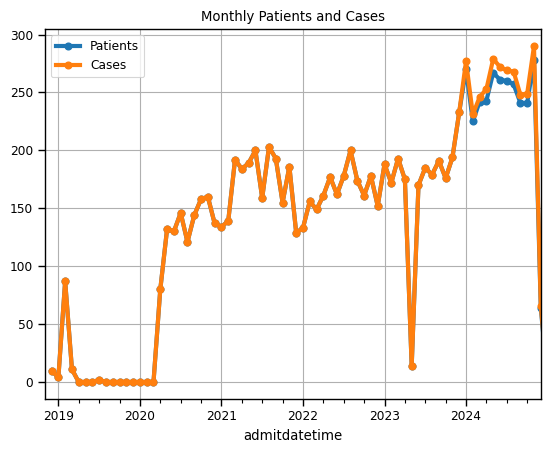

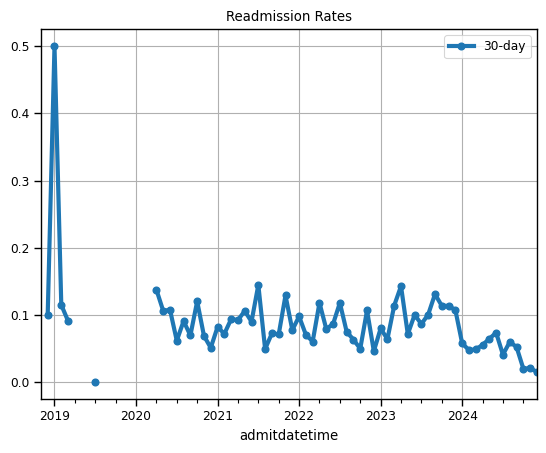

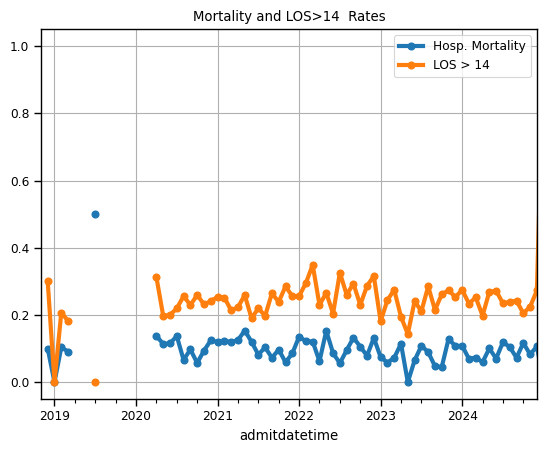

In [5]:
#######################################################################################
param['target'] = 'mrn_mortality_dict.pkl'
#param['target'] ='mrn_los_dict.pkl'
#param['target'] ='mrn_readmission_dict.pkl'
#param['readmission_time_frame'] = '30d' #'30d' or '90d' # used only if target is readmission
param['include_na_admitdates'] = False # only apply to 2024
identifier = 'id' # unique identifier merging mrn and case_id
#######################################################################################
outcome_path = 'metadata/202505/'
pre2024_outcome_fname = 'features.csv' # pre-2024 outcomes

if 'readmission' in param['target']:
    y2024_outcome_fname = 'toc_all_outcomes_2024_kmcxfer_june32025.tsv' # Newer 2024 outcomes
    fin_fld = 'fin'
else:
    y2024_outcome_fname = 'toc_all_outcomes_kmcxfer_2024_05272025.tsv' # NEW 2024 outcomes
    fin_fld = 'los_fin'


#### Load CSV to get admission dates and labels.............................................................

# outcomes 2019-2024
outcomes_pre2024 = pd.read_csv(outcome_path + pre2024_outcome_fname, header=0) #parse_dates=['admitdatetime']
if 'Unnamed: 0' in outcomes_pre2024.columns:
    outcomes_pre2024.drop('Unnamed: 0', axis=1, inplace=True)
# 
print("\n2024 Outcomes:")
#outcomes_2024 = pd.read_csv(outcome_path + '2024_outcome.csv', header=0, dtype={
#        'mrn':'Int64', 'fin':'Int64'})
outcomes_2024 = pd.read_csv(outcome_path + y2024_outcome_fname, header=0, sep='\t', parse_dates=['admitdatetime'], 
                            dtype={'mrn':'Int64', fin_fld:'Int64'})
#if 'Unnamed: 0' in outcomes_2024.columns: outcomes_2024.drop('Unnamed: 0', axis=1, inplace=True)
if 'los_fin' in outcomes_2024.columns:
    outcomes_2024.rename(columns={'los_fin': 'fin'}, inplace=True)
    
# case ID mappings
case_id_mapppings = pd.read_csv(
    'metadata/202505/intake_form_2024_nonrapid_accepted.tsv', header=0, sep='\t', dtype={
        'mrn':'Int64', 'fin':'Int64'})
outcomes_2024 = outcomes_2024.merge(case_id_mapppings[['caseid', 'fin']], on='fin', how='left')

print("Path to outcomes and metadata:", outcome_path)

# remove records having NULL admitdatetime!!! [TO DO: keep them for unsupervised tasks]
outcomes_pre2024.dropna(subset='admitdatetime', inplace=True)

if not param['include_na_admitdates']:
    outcomes_2024.dropna(subset='admitdatetime', inplace=True)
else:
    print("Predict also on patients with no admit date!")
    
print("Unique MRNs (2024):", outcomes_2024.mrn.nunique())
print("Removed rows with missing admitdatetime!")
outcomes_pre2024['admitdatetime'] = pd.to_datetime(outcomes_pre2024['admitdatetime'])
#outcomes_pre2024.loc[outcomes_pre2024.admitdatetime.isnull(), 'admitdatetime'] = outcomes_pre2024.loc[
#    outcomes_pre2024.admitdatetime.isnull()]['transfer_admit_datetime']
print("\nN. nulls:\n", outcomes_pre2024.isnull().sum().head(2))
print("\nN. unique elements:\n {}".format(outcomes_pre2024.nunique().head(2)))
#print("\nRemaining undefined admission dates:")
#print(outcomes_pre2024[outcomes_pre2024.admitdatetime.isnull()]['admitdatetime'])
print("\nDate range (Training + Evaluation): {} - {}".format(
    outcomes_pre2024.admitdatetime.min(), outcomes_pre2024.admitdatetime.max()))

# concatenate above outcome dataframes after minimal compatibility processing
outcomes_pre2024['fin'] = None
outcomes_pre2024['caseid'] = None
outcomes_pre2024['caseid'] = outcomes_pre2024['caseid'].astype(object)
outcomes_pre2024['admissionsourcedescription'] = None
outcomes_2024 = outcomes_2024.rename(columns=relevant_col_maps)
outcomes_2024['admitdatetime'] = pd.to_datetime(outcomes_2024['admitdatetime'])
if not param['include_na_admitdates']:
    outcomes_2024 = outcomes_2024[outcomes_2024['admitdatetime']>'2015']

# 30-d, 90-d column definition
if 'all_readm_6h_30d_counter' in outcomes_2024.columns:
    outcomes_2024['readm_30d_count_gt_0'] = outcomes_2024[
        'all_readm_6h_30d_counter'].astype(bool).astype(int)
else:
    readm_30d_cols = [col for col in outcomes_2024.columns if ('readm' in col) and ('_30d_counter' in col)]
    outcomes_2024['readm_30d_count_gt_0'] = outcomes_2024[readm_30d_cols].any(axis=1).astype(int)
        
readm_90d_cols = [col for col in outcomes_2024.columns if ('readm' in col)]
outcomes_2024['readm_90d_count_gt_0'] = outcomes_2024[readm_90d_cols].any(axis=1).astype(int)

print("\nDate range (Holdout): {} - {}".format(
    outcomes_2024.admitdatetime.min(), outcomes_2024.admitdatetime.max()))

outcomes = pd.concat([outcomes_pre2024, outcomes_2024], join = 'inner', axis=0)
# minimal cleaning
outcomes = outcomes[outcomes['keck_los'] >= 0]

#outcomes['transfer_source_strtflb'] = outcomes['transfer_referral_source'].map(transfer_source)

# define common identifier across all observations ('mrn' before 2024, 'caseid' from 2024)
outcomes['id'] = outcomes['caseid']
outcomes.loc[outcomes['caseid'].isnull(), 'id'] = outcomes.loc[outcomes['id'].isnull()]['mrn']

admdt_dict = outcomes[[identifier, 'admitdatetime']].set_index(identifier).to_dict()['admitdatetime']
print("Admission datetime dictionary is ready!")

# new labels
if 'readm' in param['target']:
    if param['readmission_time_frame'] == '30d':
        label_col = 'readm_30d_count_gt_0'
        print("30-day readmission is prediction target!!")
    elif param['readmission_time_frame'] == '90d':
        label_col = 'readm_90d_count_gt_0'
        print("90-day readmission is prediction target!!")
        #[,'readm_same_30d_count_gt_0', 'readm_diff_30d_count_gt_0', 'readm_60d_count_gt_0', 'readm_same_60d_count_gt_0', 
        # 'readm_diff_60d_count_gt_0', ] #'readm_diff_90d_count_gt_0', 'readm_same_90d_count_gt_0'
elif 'los' in  param['target']:
    label_col = 'keck_los'
elif 'mortality' in param['target']:
    label_col = 'inpt_mortality'
else:
    print("Undefined prediction task!!!")
    sys.exit()

label_dict = outcomes[[identifier, label_col]].set_index(identifier).to_dict()[label_col]
unique_labels = list(set(list(label_dict.values())))
print("Number of unique labels:", len(unique_labels))

    
# Plots monthly counts for patients and cases, and rates for readmission, mortality, LOS>14
####################################################################
frqz = 'ME'
####################################################################
period_patients = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz))['mrn'].nunique()
period_cases = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz)).size()
rate_30d_readm = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz)
                                          )['readm_30d_count_gt_0'].sum()/period_cases
rate_90d_readm = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz)
                                          )['readm_90d_count_gt_0'].sum()/period_cases

rate_mortality = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz)
                                          )['inpt_mortality'].sum()/period_cases
rate_los = outcomes.groupby(pd.Grouper(key='admitdatetime', freq=frqz)
                                          )['keck_los'].apply(lambda x: (x>14).sum())/period_cases


with sns.plotting_context('paper', font_scale=1):
    plt.figure(1)
    period_patients.plot(style='-o', linewidth=3, label='Patients')
    period_cases.plot(style='-o', linewidth=3, label='Cases')
    plt.legend()
    plt.grid()
    plt.title("Monthly Patients and Cases")
    plt.xlim('2018-11-01', '2024-12-31')
    
    plt.figure(2)
    rate_30d_readm.plot(style='-o', linewidth=3, label='30-day')
    #rate_90d_readm.plot(style='-o', linewidth=3, label='90-day')
    plt.legend()
    plt.grid()
    plt.title("Readmission Rates")
    plt.xlim('2018-11-01', '2024-12-31')
    
    plt.figure(3)
    rate_mortality.plot(style='-o', linewidth=3, label='Hosp. Mortality')
    rate_los.plot(style='-o', linewidth=3, label='LOS > 14')
    plt.legend()
    plt.grid()
    plt.title("Mortality and LOS>14  Rates")
    plt.xlim('2018-11-01', '2024-12-31')


### Train and Evaluate Baseline Model via TFIDF and Logistic Regression Classifier
[Table of Contents](#contents)
<a id='tfidf_training'></a>

qna_pairs/202505_pre2024_qnas_intakes
N. documents with neither label nor admit datetime: 16
filtering intake forms to keep the following fields:
 ['Transferring_Facility__c', 'Patient_Prospect__c', 'Pertinent_History_Reason_Admitted__c', 'Higher_Level_of_Care_Specifications__c', 'Smart_Transfer__c', 'Transfer_Type__c', 'Required_Level_Of_Care__c', 'Physician_Decision__c', 'Patient_Status__c', 'Insurance_Type__c', 'Current_Condition__c', 'Priority_Score__c', 'Resource_Intensive_Red_Flags__c', 'Current_Treatment__c', 'Transplant_Status__c', 'Infection_Precaution__c', 'Infection_Precaution_Needed__c', 'Infection_Precaution_Details__c']
N. documents with neither label nor admit datetime: 1648
Time to load and preprocess transfer documents: 0:00:25.728032

Loaded transfer docs... also for 2024!
Task: mortality
Actual start of holdout set: 2022-07-01 01:01:00
Fraction of testing observations: 0.59
N. supervised training: 4202
N. testing: 5967
Rate negative class (train set): 0.107
Rate nega

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


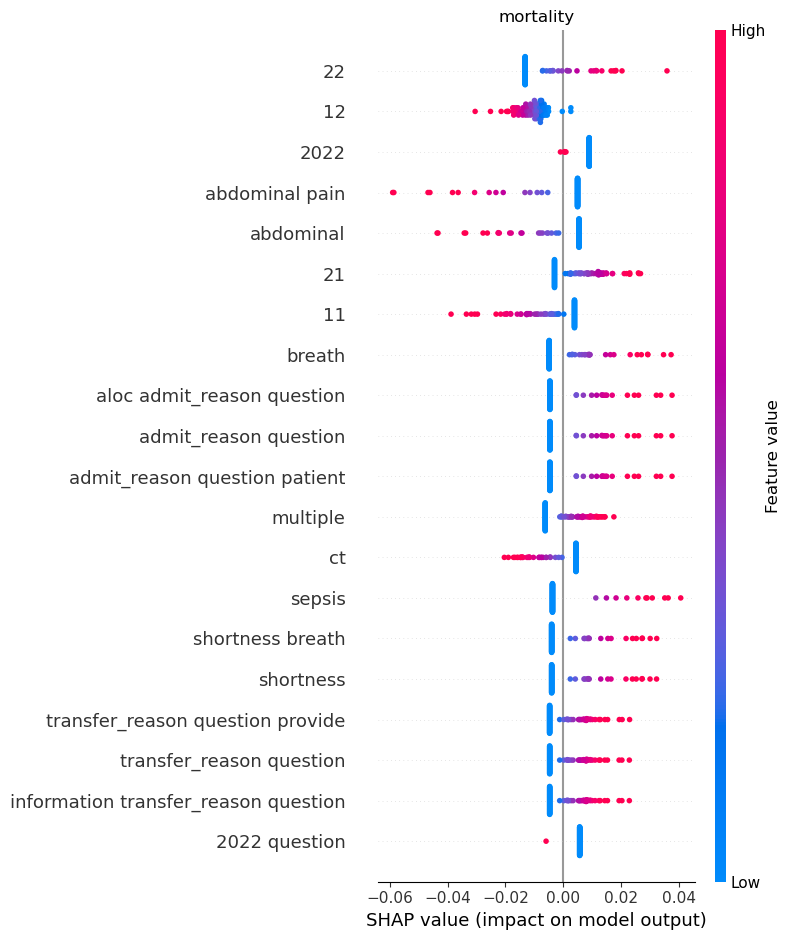

TFIDF-LR AUROC = 0.781 (95% CI: 0.763–0.800)
TFIDF-LR AUPRC = 0.273 (95% CI: 0.243–0.311)

Precision: 0.155
Recall: 0.870
F1: 0.263
Prevalence: 0.089
Median decision threshold: 0.087


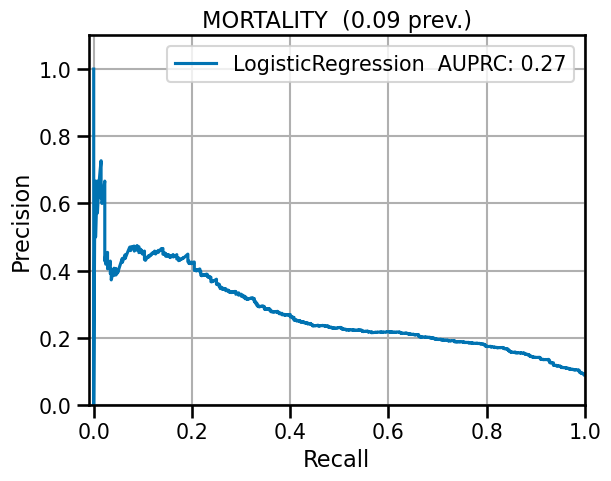

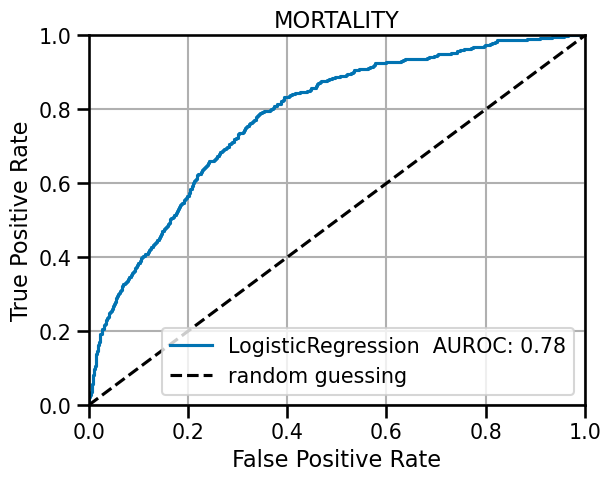

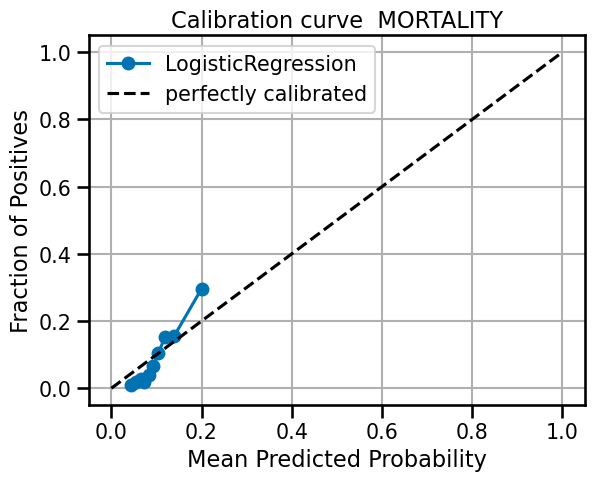

In [6]:
### Parameters #################################################################################
param['source_folder'] = 'qna_pairs/202505_pre2024_qnas_intakes' # 36 QnAs + Intake (NEW, May 2025)

param['extra_data'] = True #Set to False [TEMP]
param['split_date'] = "2022-07-01" #None #None #'2024-07-01' # Set to None to use whole 2024 data as holdout
param['train_start_date'] = None #'2021-01-01' #'2023-01-01' # Set to None to use all the training data
param['preprocess_docs'] = False
param['intake_form'] = 'filter' #'filter' #'remove', 'keep'/None
param['remove_empty_qas'] = False # sorting not implemented
param['remove_ques'] = False # sorting not implemented
param['class_rebalance'] = False
param['n_shaps'] = 1000
param['stratif_criterion'] = 'admissionsourcedescription' #'transfer_source_strtflb'
param['n_bootstraps'] = 1000 # number of bootstrap samplings for CI calculation
param['binary_los'] = True
param['los_cutoff'] = 14 # Target class is LOS > 14 days (binary task)
###############################################################################################
start_time = datetime.now()

# holdout data must much source (i.e. training and eval) data (to complete!):
if ('summaries' in param['source_folder']) and ('sonnet' in param['source_folder']):
    holdout_source_folder = 'summaries/202505_sonnet_post2023' #2024 Sonnet summaries (May 2025)
elif 'qna_pairs' in param['source_folder']:
    holdout_source_folder = 'qna_pairs/202505_post2023_qnas' #2024 - Q125 QnAs (May 2025)
else:
    print("source folder may be incorrect or corresponding holdout is NA!")
    sys.exit()

print(param['source_folder'])
ind_tr_0 = 0 # index of first training sample

#### Prepare and inspect the dataset
# pre 2024 data
source_texts, labels, adm_dts, mrns = load_sort_dataset_v3(
    param['source_folder'], label_dict, admdt_dict)
if param['remove_empty_qas']: 
    print("Will remove empty question-answer pairs from the transfer documents")
    source_texts = remove_all_empty_qnas(source_texts)
if param['intake_form'] == 'remove':
    print("removing intake!")
    source_texts = remove_intake(source_texts)
elif param['intake_form'] == 'filter':
    print("filtering intake forms to keep the following fields:\n", 
          param['intake_cols_to_keep'])
    source_texts, _ = filter_intake(source_texts, param['intake_cols_to_keep'])
else:
    print("Intake forms are kept")
# 2024 data
if param['extra_data']:
    docs_ho, labels_ho, admdts_ho, ids_ho = load_sort_dataset_v3(
        holdout_source_folder, label_dict, admdt_dict)
    if param['remove_empty_qas']:
        docs_ho = remove_all_empty_qnas(docs_ho)
    if param['intake_form'] == 'remove':
        docs_ho = remove_intake(docs_ho)
    elif param['intake_form'] == 'filter':
        docs_ho, _ = filter_intake(docs_ho, param['intake_cols_to_keep'])
    else:
        pass
    
    source_texts.extend(docs_ho)
    labels.extend(labels_ho)
    adm_dts.extend(admdts_ho)
    mrns.extend(ids_ho) 

if param['preprocess_docs']:
    source_texts = [preprocess_text(doc) for doc in source_texts] 
    print("Additional document preprocessing is completed!")

end_time = datetime.now()
print(f"Time to load and preprocess transfer documents: {end_time - start_time}")
        
print("\nLoaded transfer docs... also for 2024!")
    
print("Task:", param['target'].split('_')[1])
if 'readmission' in param['target']:
    print(param['readmission_time_frame'])
    
binary_classifier = ('los' not in param['target']) or (
    ('los' in param['target']) and param['binary_los'])

if not binary_classifier:
    param['class_rebalance'] = False
elif ('los' in param['target']) and (param['binary_los']==True):
    # Prepare LOS binary labels
    labels = [int(el>param['los_cutoff']) for el in labels]
    print('LOS as *binary* prediction task!')

           
if param['class_rebalance']:
    class_weights = 'balanced'
    print("Balanced class weights!")
else:
    class_weights = None
    
if param['train_start_date']:
    ind_tr_0 = len([admdt for admdt in adm_dts if admdt 
                    <= pd.to_datetime(param['train_start_date'])])
    print("Actual start of Supervised training set:", adm_dts[ind_tr_0])

if param['split_date']:
    ho_splitdate = pd.to_datetime(param['split_date'])
    if ho_splitdate >= adm_dts[0] <= adm_dts[-1]:
        ind_ho_0 = len([admdt for admdt in adm_dts if admdt <= ho_splitdate])
        print("Actual start of holdout set:", adm_dts[ind_ho_0])
    else:
        print("Invalid split date!")
        sys.exit()

if not binary_classifier:
    print("Average LOS:", np.mean(labels))

# Split docs for training and testing
train = source_texts[ind_tr_0:ind_ho_0]
y_tr = labels[ind_tr_0:ind_ho_0]
test = source_texts[ind_ho_0:]
y_ts = labels[ind_ho_0:]
mrn_ts = mrns[ind_ho_0:]

tfidf_training_set = train
if ind_tr_0:
    tfidf_training_set = source_texts[:ind_tr_0]
    tfidf_training_set.extend(train)

print("Fraction of testing observations: {:.2f}".format(len(y_ts)/(len(y_tr)+len(y_ts))))
print("N. supervised training:", len(y_tr))
print("N. testing:", len(y_ts))

if binary_classifier:
    print("Rate negative class (train set): {:.3f}".format(sum(y_tr)/len(y_tr)))
    print("Rate negative class (test set): {:.3f}".format(sum(y_ts)/len(y_ts)))
else:
    print("Average LOS (train set): {:.3f}".format(np.mean(y_tr)))
    print("Average LOS (test set): {:.3f}".format(np.mean(y_ts)))

print("N. TFIDF training samples:", len(tfidf_training_set))
start_time = datetime.now()

#### Create TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=.95, max_features=None,
                       strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                       ngram_range=(1,3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                       stop_words='english')
tfidf.fit(tfidf_training_set)

#### Transform train and eval data into TFIDF features
#train_tfidf = tfidf.transform(tfidf_training_set)
train_tfidf = tfidf.transform(train)
test_tfidf = tfidf.transform(test)
print("N. TFIDF features:", train_tfidf.shape[1])

#### Train the Logistic Regression model
if binary_classifier:
    lmodel = LogisticRegression(C=1.0, class_weight=class_weights)
    #lmodel = RandomForestClassifier(n_estimators=500)
else:
    # Predict lenght of stay
    lmodel = Ridge(alpha=2)
    #lmodel = PoissonRegressor(alpha=1.0)

print("\nModel: {}\n".format(lmodel))

lmodel.fit(train_tfidf, y_tr)
end_time = datetime.now()
print(f"Trained models in: {end_time - start_time}")

# prediction task for plots
prediction_task = param['target'].split('_')[1]
if 'readmission' in param['target']:
    prediction_task = " ".join([param['readmission_time_frame'], prediction_task])

### SHAP Analysis
X_bckgrnd = train_tfidf[-1 * param['n_shaps']:]
explainer = shap.LinearExplainer(lmodel
                                 , X_bckgrnd
                                 , feature_perturbation='interventional'
                                 , model_output='logit')

# Compute SHAP values
X_plot = X_bckgrnd[:100].toarray()
shap_values = explainer.shap_values(X_plot)

# Summary plot
shap.summary_plot(
    shap_values, 
    X_plot, 
    feature_names=tfidf.get_feature_names_out(),
    show=False
)
plt.title(prediction_task)
plt.tight_layout()
plt.show()

#### Evaluate on test set
if binary_classifier:
    y_pred = lmodel.predict_proba(test_tfidf)
    # Compute binary classifcation metrics
    auroc, auroc_low, auroc_up = bootstrap_ci(y_true=y_ts, y_scores=y_pred[:, 1], 
                                              metric_fn=roc_auc_score,
                                              n_bootstraps=param['n_bootstraps'], alpha=0.95)
    auprc, auprc_low, auprc_up = bootstrap_ci(y_ts, y_pred[:, 1],
                                              average_precision_score, param['n_bootstraps'], 0.95)
    print(f"TFIDF-LR AUROC = {auroc:.3f} (95% CI: {auroc_low:.3f}–{auroc_up:.3f})")
    print(f"TFIDF-LR AUPRC = {auprc:.3f} (95% CI: {auprc_low:.3f}–{auprc_up:.3f})")
    
    # stratified performance analysis
    #stratified_performance(y_ts, y_pred[:, 1], mrn_ts, outcomes, param['stratif_criterion'], 50)
    
    # decision analysis
    decision_threshold = np.median(y_pred[:,1])
    decisions = (y_pred[:,1] > decision_threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_ts, decisions, average='binary')
    print("\nPrecision: {:.3f}\nRecall: {:.3f}\nF1: {:.3f}\nPrevalence: {:.3f}".format(
        precision, recall, f1, sum(y_ts)/len(y_ts)))
    print("Median decision threshold: {:.3f}".format(decision_threshold))
    
    # performance plots
    performance_plots(y_ts, y_pred[:,1], prediction_task, model_name=str(lmodel).split('(')[0])
    
else:
    y_pred = lmodel.predict(test_tfidf)
    print("MAE:", mean_absolute_error(y_ts, y_pred))
    print("R2:", r2_score(y_ts, y_pred))
    print("need more regression metrics .. ")
    
    
# put predictions in a dataframe
predictions_df = pd.DataFrame({'ids': mrn_ts,
                               'y_true': y_ts,
                               'y_pred': y_pred[:, 1],
                               'admitdatetime': adm_dts[ind_ho_0:]})

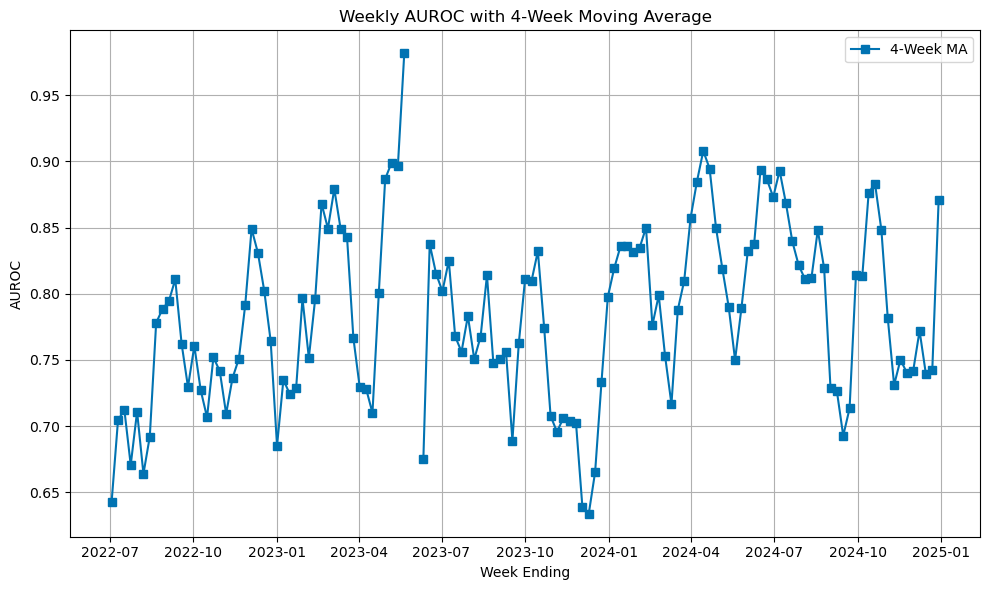

In [10]:

# ── Compute weekly AUROC ───────────────────────────────────────────────────────
# Group by calendar week (Sunday–Saturday by default) and compute AUROC
weekly_auroc = (
    predictions_df
    .set_index('admitdatetime')
    .groupby(pd.Grouper(freq='W'))
    .apply(lambda grp: 
           roc_auc_score(grp['y_true'], grp['y_pred'])
           if grp['y_true'].nunique() > 1
           else np.nan
    )
    .rename('auroc')
)

# ── Smooth with a 4‑week moving average ────────────────────────────────────────
smoothed_auroc = weekly_auroc.rolling(window=4, min_periods=1).mean()

# ── Plotting ─────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
#plt.plot(weekly_auroc.index, weekly_auroc, marker='o', label='Weekly AUROC')
plt.plot(smoothed_auroc.index, smoothed_auroc, marker='s', label='4‑Week MA')
plt.xlabel('Week Ending')
plt.ylabel('AUROC')
plt.title('Weekly AUROC with 4‑Week Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sys.exit()

### Experiment Evaluation

In [ ]:
if 'experiment_names' not in globals():
    label_l = []
    predictions = []
    experiment_names = []

target_param = 'preprocess_docs' #'train_start_date'  
predictions.append(y_pred[:, 1])
label_l.append(y_ts)
if param[target_param] == None:
    experiment_names.append("")
else:
    experiment_names.append(param[target_param])

print("N. experiments:", len(predictions))
print("Experiments:", experiment_names)
if len(experiment_names) > 1:
    performance_plots(label_l, predictions, prediction_task, experiment_names)

In [ ]:
# CIs and CI differences
ref_pred = predictions[0]
for pred, exprm in zip(predictions, experiment_names):
    print("\n", exprm)
    auroc, auroc_low, auroc_up = bootstrap_ci(y_true=y_ts, y_scores=pred, 
                                              metric_fn=roc_auc_score,
                                              n_bootstraps=param['n_bootstraps'], alpha=0.95)
    auprc, auprc_low, auprc_up = bootstrap_ci(y_ts, pred,
                                              average_precision_score, param['n_bootstraps'], 0.95)
    print(f"AUROC = {auroc:.3f} (95% CI: {auroc_low:.3f}–{auroc_up:.3f})")
    print(f"AUPRC = {auprc:.3f} (95% CI: {auprc_low:.3f}–{auprc_up:.3f})")
    if len(experiment_names) < 2: #exprm == "keep": #pred == ref_pred:
        continue
    # Difference CIs
    auroc_dif_bsl_enc, auroc_dif_low, auroc_dif_up = bootstrap_diff_ci_paired(
        y_ts, ref_pred, pred, roc_auc_score, 1000, .95, SEED)
    print(f"AUROC difference = {auroc_dif_bsl_enc:.3f} \
    (95% CI: {auroc_dif_low:.3f}–{auroc_dif_up:.3f})") # part of previous line of code
    auprc_dif_bsl_enc, auprc_dif_low, auprc_dif_up = bootstrap_diff_ci_paired(
        y_ts, ref_pred, pred, average_precision_score, 1000, .95, SEED)
    print(f"AUPRC difference = {auprc_dif_bsl_enc:.3f} \
    (95% CI: {auprc_dif_low:.3f}–{auprc_dif_up:.3f})") # part of previous line of code
    

### Hyperparameter Tuning
[Table of Contents](#contents)
<a id='hyperparameter_tuning'></a>

In [ ]:
#sys.exit()
lmodel.get_params()
#search_default.best_params_
#search_default.best_score_
#search_default.cv_results_

In [ ]:
###########################################################################
param['n_iter'] = 10 # number of 
param['cv_type'] = 'temporal' #'temporal': training samples older than testing# 'random': 5-fold random cross validation
param['deafult_params'] = False
param['n_folds'] = 4
###########################################################################
start_time = datetime.now()

# tf-idf + logistic regression pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=None,
        strip_accents='unicode',
        analyzer='word', 
        token_pattern=r'\w{1,}',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True,
        stop_words='english'
    )),
    ('lmodel', LogisticRegression(max_iter=1000, solver='sag'))
    
])

# default hyperparameters
param_defaults = {
    "tfidf__min_df":       [5],
    "tfidf__max_df":       [0.95],
    "tfidf__ngram_range":  [(1, 3)],
    #"tfidf__max_features": [None],
    "lmodel__C":              [1.0],
    "lmodel__class_weight":   [None],
    "lmodel__max_iter":       [1000],
    "lmodel__solver":         ['sag'],                
}

# parameter distributions
param_dist = {
    "tfidf__min_df":       randint(1, 5),
    "tfidf__max_df":       uniform(loc=.9, scale=0.1),
    "tfidf__ngram_range":  [(1,1), (1,2), (1,3)],
    #"tfidf__max_features": [None, 100_000, 150_000],
    "lmodel__C":              loguniform(1e-3, 1e2),
    "lmodel__class_weight":   [None, "balanced"],
    
}

# Time-aware CV split
tscv = TimeSeriesSplit(
    n_splits=param['n_folds'],
    max_train_size=None,   # or set rolling window
)

if param['deafult_params']:
    param['n_iter'] = 1
    print("Will train with deafult hyperparameters")
    variable_parameters = param_defaults
else:
    print("Will do {} randomized hyperparameter search iterations".format(param['n_iter']))
    print("Tuning:\n", param_dist)
    variable_parameters = param_dist

print("N. folds:", param['n_folds'])
    
if param['cv_type'] == 'temporal':
    cv_type = tscv
    print("Temporal cross-validation: training samples always older than testing ones.")
elif param['cv_type'] == 'random':
    cv_type = param['n_folds'] # no
    print("Standard K-fold cross-validation")


hyperparam_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=variable_parameters, #param_dist, #param_defaults,
    n_iter=param['n_iter'],    # only defaults
    cv=cv_type,
    scoring='average_precision', #"roc_auc",
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)


with parallel_backend("loky"), tqdm_joblib(
    tqdm(desc="RandomizedSearchCV", total=param['n_iter'])):
    hyperparam_search.fit(train, y_tr)

best_model = hyperparam_search.best_estimator_

end_time = datetime.now()
print(f"Randomized Hyperparameter Search done in: {end_time - start_time}")

print("Best hyperparameters:", hyperparam_search.best_params_)  # will be exactly your defaults
print("Best CV score: {:.3f}".format(hyperparam_search.best_score_))

tfidf_vect = best_model.named_steps['tfidf']
print(f"N. TF-IDF features: {len(tfidf_vect.get_feature_names_out())}")


y_pred_hps = best_model.predict_proba(test)
# Compute binary classifcation metrics
auroc, auroc_low, auroc_up = bootstrap_ci(y_true=y_ts, y_scores=y_pred_hps[:, 1], 
                                          metric_fn=roc_auc_score,
                                          n_bootstraps=param['n_bootstraps'], alpha=0.95)
auprc, auprc_low, auprc_up = bootstrap_ci(y_ts, y_pred_hps[:, 1],
                                          average_precision_score, param['n_bootstraps'], 0.95)
print(f"TFIDF-LR AUROC = {auroc:.3f} (95% CI: {auroc_low:.3f}–{auroc_up:.3f})")
print(f"TFIDF-LR AUPRC = {auprc:.3f} (95% CI: {auprc_low:.3f}–{auprc_up:.3f})")
    

# performance plots
prediction_task = param['target'].split('_')[1]
if 'readmission' in param['target']:
    prediction_task = " ".join([param['readmission_time_frame'], prediction_task])
experiments = ["deafult hyperpars.", "searched hyperpars."]
performance_plots([y_ts, y_ts], [y_pred[:,1], y_pred_hps[:,1]], prediction_task, model_name=experiments)


auroc_dif_bsl_enc, auroc_dif_low, auroc_dif_up = bootstrap_diff_ci_paired(
    y_ts, y_pred_hps[:,1], y_pred[:,1], roc_auc_score, 1000, .95, SEED)
print(f"AUROC difference = {auroc_dif_bsl_enc:.3f} \
    (95% CI: {auroc_dif_low:.3f}–{auroc_dif_up:.3f})") # part of previous line of code
auprc_dif_bsl_enc, auprc_dif_low, auprc_dif_up = bootstrap_diff_ci_paired(
    y_ts, y_pred_hps[:,1], y_pred[:,1], average_precision_score, 1000, .95, SEED)
print(f"AUPRC difference = {auprc_dif_bsl_enc:.3f} \
    (95% CI: {auprc_dif_low:.3f}–{auprc_dif_up:.3f})") # part of previous line of code
    

In [ ]:
pd.DataFrame(hyperparam_search.cv_results_).mean_test_score.describe()

In [ ]:
sys.exit()

#### Dataset inspection - Make sure this does not interfere with datasets and labels used by encoder!!!

In [ ]:
"""
#Dataset Inspection
print("Dataset inspection:")
docs, lbls = load_dataset(source_folder, label_dict)
#docs, lbls = load_dataset_remove_empty_qas(source_folder, label_dict)
#docs, lbls = load_dataset_remove_ques(source_folder, label_dict)

print("N documents:", len(docs))
#print(type(docs))
print("Total chars original dataset:", 83179791)
print("Total chars loaded dataset:", sum([len(doc) for doc in docs]))

erq = '"question": "Was this patient seen in the Emergency Room?"'
#erq = '"Was this patient seen in the Emergency Room?"'

# ER question with no answer
erq_na_ans = '{"question": "Was this patient seen in the Emergency Room?", "er": ""}'#'\n\n'
of_na_ans = '{"question": "What was the severity of organ failure?", "organ_failure": ""}'#'\n\n'

for qna_out in [of_na_ans, erq_na_ans]:
    print("QnA to remove\n", qna_out)
    print("N. occurrences in dataset:", len([doc for doc in docs if qna_out in doc]))
#"""


intake_cols_to_keep = [
    "MRN__c", "FIN__c", "Patient_Name_Formula__c", "Transferring_Facility__c",
    "Patient_Prospect__c", "Pertinent_History_Reason_Admitted__c",
    "Higher_Level_of_Care_Specifications__c", "Smart_Transfer__c",
    "Transfer_Type__c", "Required_Level_Of_Care__c", "Physician_Decision__c",
    "Date_of_Birth_Formula__c", "Patient_Status__c", "Insurance_Type__c",
    "Current_Condition__c", "Priority_Score__c", "Resource_Intensive_Red_Flags__c",
    "Current_Treatment__c", "Transplant_Status__c", "Infection_Precaution__c",
    "Infection_Precaution_Needed__c", "Infection_Precaution_Details__c"
]

read_compiled_QnA_from_string

print('Skipped dataset inspection')